# Load ds005514 and start training (see below to read presaved data)

In [1]:
from eegdash import EEGDash
from eegdash.data_utils import EEGDashBaseRaw

eegdashdata = EEGDash(is_public=False)
records = eegdashdata.findrecord({'dataset': 'ds005514', 'task': 'RestingState'})
# records = records[0:10]

print("number of records: ", len(records))
print("first record: ", records[0]) # current call




number of records:  269
first record:  {'_id': ObjectId('6789a3c766ea5ef303140d0c'), 'data_name': 'ds005514_sub-NDARRW481GFE_task-RestingState_eeg.set', 'dataset': 'ds005514', 'bidspath': 'ds005514/sub-NDARRW481GFE/eeg/sub-NDARRW481GFE_task-RestingState_eeg.set', 'subject': 'NDARRW481GFE', 'task': 'RestingState', 'session': '', 'run': '', 'sampling_frequency': 500, 'modality': 'EEG', 'channel_names': ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30', 'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E61', 'E62', 'E63', 'E64', 'E65', 'E66', 'E67', 'E68', 'E69', 'E70', 'E71', 'E72', 'E73', 'E74', 'E75', 'E76', 'E77', 'E78', 'E79', 'E80', 'E81', 'E82', 'E83', 'E84', 'E85', 'E86', 'E

In [2]:
from braindecode.datasets import BaseDataset, BaseConcatDataset
gender_to_label = {'M': int(0), 'F': int(1)}

allEEGDash = []
for record in records:
    s3_path = eegdashdata.get_s3path(record)
    sfreq = record['sampling_frequency']
    nchans = record['nchans']
    ntimes = record['ntimes']
    ch_names = record['channel_names']
    ch_types = record['channel_types']
    s3_path = eegdashdata.get_s3path(record)
    eegdash = BaseDataset(EEGDashBaseRaw(s3_path, {'sfreq': sfreq, 'nchans': nchans, 'n_times': ntimes, 'ch_types': ch_types, 'ch_names': ch_names}, preload=False), target_name='genderbin')
    eegdash.set_description({'age': record['participantinfo']['age'], 'gender': record['participantinfo']['gender'], 'genderbin': gender_to_label[record['participantinfo']['gender']], 'subject': record['subject']})
    allEEGDash.append(eegdash)


c:\Users\adelorme\AppData\Local\anaconda3\envs\gpu-test\Lib\site-packages\braindecode\datasets\base.py:131: UserWarning: 'genderbin' not in description. '__getitem__'will fail unless an appropriate target is added to description.
  warnings.warn(f"'{name}' not in description. '__getitem__'"


In [3]:
eegdash_braindecode = BaseConcatDataset(allEEGDash)

In [4]:
import numpy as np

res = eegdash_braindecode.description
res

,age,gender,genderbin,subject
0,5.7012,M,0,NDARRW481GFE
1,13.5951,M,0,NDARTE553VC1
2,12.0696,F,1,NDARFJ488VPT
3,10.7882,F,1,NDARHT403JJJ
4,12.5762,M,0,NDARYW170CAA
...,...,...,...,...
264,11.0979,F,1,NDARYL284NDM
265,9.9341,M,0,NDARPH105ZFF
266,8.2833,F,1,NDARFM870UHU
267,6.4541,M,0,NDARUY024RVP


Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
sampling_freq: 500.0
(array([[ 2402.36499023,  2358.11035156,  2292.43237305, ...,
        -3395.13867188, -3489.63623047, -3587.44360352]]), array([ 10.   ,  10.002,  10.004, ..., 445.466, 445.468, 445.47 ]))
-3617.61279296875 4021.9267578125


c:\Users\adelorme\AppData\Local\anaconda3\envs\gpu-test\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


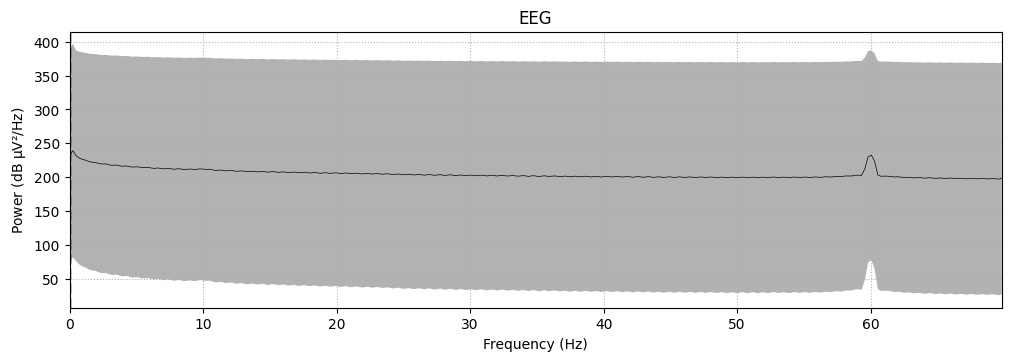

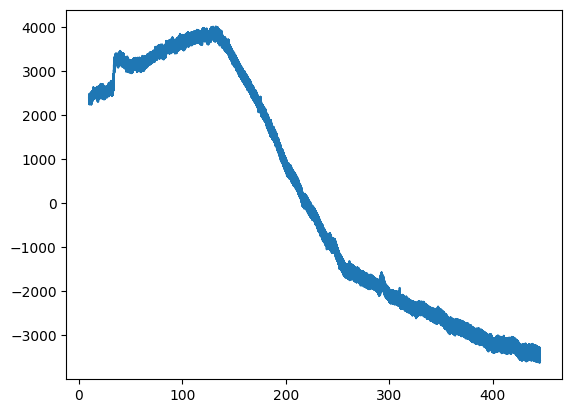

In [5]:
import matplotlib.pyplot as plt
import numpy as np
raw = eegdash_braindecode.datasets[1].raw
fig = raw.compute_psd(fmax=70).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
sampling_freq = raw.info["sfreq"]
print('sampling_freq:', sampling_freq)
start_stop_seconds = np.array([10, 500])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]
print(raw_selection)
x = raw_selection[1]
y = raw_selection[0].T
print(np.min(y),np.max(y))
plt.figure()
plt.plot(x, y)
plt.show()

In [6]:
from braindecode.preprocessing import (preprocess, Preprocessor, create_fixed_length_windows)

preprocessors = [   
    Preprocessor("filter", l_freq=1, h_freq=55),
    Preprocessor("resample", sfreq=125)
]

# preprocess(eegdash_braindecode, preprocessors, n_jobs=-1) #, overwrite=True)
# resave the data as it is being preprocessed when overwrite=True

windows_ds = create_fixed_length_windows(eegdash_braindecode, start_offset_samples=0, stop_offset_samples=None,
        window_size_samples=614,
        window_stride_samples=1000, drop_last_window=True,
        preload=False) 

In [7]:
import os
# save all the data
if True:
    os.makedirs('data/hbn_preprocessed_restingstate', exist_ok=True)
    windows_ds.save('data/hbn_preprocessed_restingstate', overwrite=True)
else:
    print('NOTHING WAS DONE. CHANGE THE CONDITIONAL STATEMENT.')

Writing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\0\0-raw.fif
Closing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\0\0-raw.fif
[done]
Writing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\1\1-raw.fif
Closing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\1\1-raw.fif
[done]
Writing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\2\2-raw.fif
Closing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\2\2-raw.fif
[done]
Writing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\3\3-raw.fif
Closing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\3\3-raw.fif
[done]
Writing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\4\4-raw.fif
Closing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\4\4-raw.fif
[done]
Writing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\5\5-raw.fif
Closing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\5\5-raw.fif
[done]
Writing d:\EEG-Dash-Da

c:\Users\adelorme\AppData\Local\anaconda3\envs\gpu-test\Lib\site-packages\mne\_fiff\utils.py:76: RuntimeWarning: invalid value encountered in cast
  one = np.asarray(one, dtype=data_view.dtype)


Closing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\24\24-raw.fif
[done]
Writing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\25\25-raw.fif
Closing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\25\25-raw.fif
[done]
Writing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\26\26-raw.fif
Closing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\26\26-raw.fif
[done]
Writing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\27\27-raw.fif
Closing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\27\27-raw.fif
[done]
Writing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\28\28-raw.fif
Closing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\28\28-raw.fif
[done]
Writing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\29\29-raw.fif
Closing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\29\29-raw.fif
[done]
Writing d:\EEG-Dash-Data\tests\data\hbn_preprocessed_restingstate\30\30-raw.fi

# Start here to load presaved data

In [1]:
# check if windows_ds is a variable in the workspace and delete it
if 'windows_ds' in locals():
    del windows_ds

In [2]:
# if you run this cell as it loads all the data from disk

import os
from braindecode.datautil import load_concat_dataset

print("Loading data from disk")
windows_ds = load_concat_dataset(path='data/hbn_preprocessed_restingstate', preload=False)


Loading data from disk


In [3]:
from braindecode.datasets import BaseDataset, BaseConcatDataset
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

subject_genders = windows_ds.description['genderbin']
random_state = 42

# Get balanced indices for male and female subjects
male_indices = np.where(subject_genders == 0)[0]
female_indices = np.where(subject_genders == 1)[0]
n_samples = min(len(male_indices), len(female_indices))
balanced_indices = np.concatenate([male_indices[:n_samples], female_indices[:n_samples]])

# First split: separate test set (20%)
train_val_indices, test_indices = train_test_split(balanced_indices, test_size=0.2, stratify=subject_genders[balanced_indices], random_state=random_state)

# Second split: separate train and validation sets (75% train, 25% validation of remaining data)
# This gives approximately 60/20/20 split of the original data
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.25, stratify=subject_genders[train_val_indices],random_state=random_state)

# Create datasets
train_ds = BaseConcatDataset([windows_ds.datasets[i] for i in train_indices])
val_ds = BaseConcatDataset([windows_ds.datasets[i] for i in val_indices])
test_ds = BaseConcatDataset([windows_ds.datasets[i] for i in test_indices])

# train_ds2 = [[ds[0].reshape(1, ds[0].shape[0], ds[0].shape[1]), ds[1], ds[2]] for ds in train_ds]
# test_ds2  = [[ds[0].reshape(1, ds[0].shape[0], ds[0].shape[1]), ds[1], ds[2]] for ds in test_ds]
# print("Shape of train_ds2[0][0]:", train_ds2[0][0].shape)

train_loader = DataLoader(train_ds, batch_size=200, shuffle=True)
val_loader =  DataLoader(val_ds, batch_size=200, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=200, shuffle=True)

# Print shapes and sizes to verify split
print("Shape of train_ds[0][0]:", train_ds[0][0].shape)
print(f"Number of samples - Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")
print(f"Train gender balance: {np.mean(train_ds.description['genderbin']):.2f}")
print(f"Val gender balance: {np.mean(val_ds.description['genderbin']):.2f}")
print(f"Test gender balance: {np.mean(test_ds.description['genderbin']):.2f}")

Shape of train_ds[0][0]: (129, 614)
Number of samples - Train: 22182, Val: 8105, Test: 7406
Train gender balance: 0.50
Val gender balance: 0.51
Test gender balance: 0.49


In [4]:
dataiter = iter(train_loader)
first_item, label, sz = dataiter.__next__() # question why is the label lost here 
label

tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 1])

In [7]:
from torch import nn
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet
from torchinfo import summary

# re-import models_dung_2021
import importlib
import models_dung_2021
importlib.reload(models_dung_2021)  # This ensures we get the latest version
from models_dung_2021 import (create_model_original_129_614, create_model_vgg16)

cuda = torch.cuda.is_available()  # check if CUDA GPU is available
mps = torch.backends.mps.is_available()  # check if MPS (Apple GPU) is available

if cuda:
    device = torch.device("cuda")
elif mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

if cuda:
    torch.backends.cudnn.benchmark = True
    
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 2
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_channels = windows_ds[0][0].shape[0]
input_window_samples = windows_ds[0][0].shape[1]

model_name = 'shallow' #'shallow' #'original' #'vgg16'
if model_name == 'vgg16':
    model = create_model_vgg16((1, 1, 129, 614))
    print(summary(model, input_size=(1, 1, 129, 614), col_names=["input_size", "output_size", "num_params", "kernel_size"])) # puts the model back on CPU
elif model_name == 'original':
    model = create_model_original_129_614()
    print(summary(model, input_size=(1, 1, 129, 614), col_names=["input_size", "output_size", "num_params", "kernel_size"])) # puts the model back on CPU
else:
    model = ShallowFBCSPNet(
        n_channels,
        n_classes,
        input_window_samples=input_window_samples,
        final_conv_length="auto",
    )
    print(model)

# Send model to GPU
if cuda:
    model.cuda()
    
model.to(device)
print(f"Model device: {next(model.parameters()).device}")


c:\Users\adelorme\AppData\Local\anaconda3\envs\gpu-test\Lib\site-packages\braindecode\util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(
c:\Users\adelorme\AppData\Local\anaconda3\envs\gpu-test\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
c:\Users\adelorme\AppData\Local\anaconda3\envs\gpu-test\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 129, 614]             [1, 2]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 129, 614]             [1, 129, 614, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 129, 614, 1]          [1, 1, 614, 129]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 614, 129]          [1, 40, 590, 1]           207,440                   --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 590, 1]           [1, 40, 590, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 590, 1]           [1, 40, 590, 1]           --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 590, 1]           [1, 40, 35, 1]            --                        [75, 1]
├─Express

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Assuming 'model' is your ShallowFBCSPNet instance
# Assuming 'dataloader' is your DataLoader instance
def normalize_data(data):
    return (data - data.mean()) / (data.std() + 1e-8)

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 20  # Number of epochs
for epoch in range(n_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for batch_idx, (data, target, sz) in enumerate(train_loader):
        # Move data to the appropriate device (e.g., GPU if available)
        data = normalize_data(data)
        if model_name == 'vgg16' or model_name == 'original':
            data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        data, target = data.to(device), target.to(device)
        # print(f"Model device: {next(model.parameters()).device}")
        # print(f"Data device: {data.device}, Data type: {data.dtype}")
        # print(f"Target device: {target.device}, Target type: {target.dtype}")        
        # print(data.shape)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(data)
        loss = F.cross_entropy(outputs, target)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()

    model.eval()
    correct = np.array([])
    total = 0
    for batch_idx, (data, target, sz) in enumerate(val_loader):
        data = normalize_data(data)
        if model_name == 'vgg16' or model_name == 'original':
            data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        data, target = data.to(device), target.to(device)

        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct = np.concatenate((correct, (predicted == target).to("cpu").numpy()))

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val: {np.mean(correct):.4f}")

Epoch [1/20], Loss: 5.0421, Val: 0.4825
Epoch [2/20], Loss: 3.5793, Val: 0.5149
Epoch [3/20], Loss: 2.4043, Val: 0.5070


KeyboardInterrupt: 

In [13]:
import torch

print(f"Allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
print(f"Cached: {torch.cuda.memory_reserved()/1024**2:.2f} MB")


Allocated: 336.32 MB
Cached: 29802.00 MB


In [ ]:
torch.cuda.empty_cache()
def find_max_batch_size(model, max_batch_size=1024):
    batch_size = 1
    while batch_size <= max_batch_size:
        try:
            # Create dummy input
            x = torch.randn(batch_size, 1, n_channels, input_window_samples, device='cuda')
            output = model(x)
            torch.cuda.empty_cache()
            batch_size *= 2
        except RuntimeError as e:
            if "out of memory" in str(e):
                torch.cuda.empty_cache()
                return batch_size // 2
            raise e
    return batch_size // 2

optimal_batch_size = find_max_batch_size(model)
print(f"Optimal batch size: {optimal_batch_size}")

In [39]:
#
tmp = (predicted == target).to("cpu").numpy()
correct = np.concatenate((correct, tmp))
# append all elements of tmp to correct
#[correct.append(tmp2) for tmp2 in tmp]
#correct
correct

array([1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 0.

In [44]:
# test the model
model.eval()  # Set the model to evaluation mode
correct = []
total = 0

with torch.no_grad():  # Disable gradient computation
    for data, target in test_loader2:
        data = normalize_data(data)
        if model_name == 'vgg16' or model_name == 'original':
            data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        data, target = data.to(device), target.to(device)
        data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.long)
        
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct.append((predicted == target).sum().item())

print(f"Accuracy: {100 * np.sum(correct) / total:.2f}%")

# compute bootstrap and 95% confidence interval for correct

        

Accuracy: 37.50%


In [45]:
# compute bootstrap and 95% confidence interval for correct
n_bootstrap = 1000
bootstrap_accuracies = []

for _ in range(n_bootstrap):
    # Sample with replacement from correct list
    bootstrap_sample = np.random.choice(correct, size=len(correct), replace=True)
    bootstrap_acc = 100 * np.sum(bootstrap_sample) / total
    bootstrap_accuracies.append(bootstrap_acc)

# Calculate 95% confidence interval
ci_lower = np.percentile(bootstrap_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_accuracies, 97.5)
mean_acc = np.mean(bootstrap_accuracies)

print(f"Mean Accuracy: {mean_acc:.2f}%")
print(f"95% CI: [{ci_lower:.2f}%, {ci_upper:.2f}%]")

Mean Accuracy: 37.47%
95% CI: [30.00%, 45.07%]


In [6]:
def calculate_batch_memory(model, batch_size, input_shape, precision=32):
    """
    Calculate memory usage without allocating memory
    
    Args:
        model: PyTorch model
        batch_size: int
        input_shape: tuple of input dimensions (excluding batch)
        precision: bit precision (16 or 32)
    
    Returns:
        Memory usage in GB
    """
    bytes_per_element = precision / 8  # Convert bits to bytes
    
    # Input size
    input_size = batch_size * np.prod(input_shape) * bytes_per_element
    
    # Model parameters
    param_size = sum(p.numel() for p in model.parameters()) * bytes_per_element
    
    # Gradients (same size as parameters during training)
    gradient_size = param_size
    
    # Optimizer states (assumes Adam - 2 states per parameter)
    optimizer_size = param_size * 2
    
    # Estimate activation maps (this is approximate and architecture-dependent)
    # Typically 2-3x input size for most architectures
    activation_size = input_size * 3
    
    # Buffer for intermediate computations (rough estimate)
    buffer_size = input_size * 2
    
    total_bytes = (input_size + param_size + gradient_size + 
                  optimizer_size + activation_size + buffer_size)
    
    total_gb = total_bytes / (1024**3)  # Convert to GB
    
    print(f"Estimated memory usage for batch_size={batch_size}:")
    print(f"Input tensors: {input_size/1024**3:.2f} GB")
    print(f"Model parameters: {param_size/1024**3:.2f} GB")
    print(f"Gradients: {gradient_size/1024**3:.2f} GB")
    print(f"Optimizer states: {optimizer_size/1024**3:.2f} GB")
    print(f"Activation maps: {activation_size/1024**3:.2f} GB")
    print(f"Computation buffers: {buffer_size/1024**3:.2f} GB")
    print(f"Total estimated: {total_gb:.2f} GB")
    
    return total_gb

# Calculate for your model
input_shape = (1, 129, 614)  # Adjust based on your model
gpu_memory = 24  # Your GPU memory in GB
batch_size = 256  # Start with a reasonable batch size

memory_usage = calculate_batch_memory(model, batch_size, input_shape)
if memory_usage < gpu_memory * 0.8:  # Leave 20% margin for safety
    print(f"Batch size {batch_size} should fit in memory")
else:
    print(f"Batch size {batch_size} might be too large")

Estimated memory usage for batch_size=256:
Input tensors: 0.08 GB
Model parameters: 0.06 GB
Gradients: 0.06 GB
Optimizer states: 0.13 GB
Activation maps: 0.23 GB
Computation buffers: 0.15 GB
Total estimated: 0.71 GB
Batch size 256 should fit in memory


In [398]:
# perform cross-validation randonly selectings windows_ds among len(windows_ds)
from sklearn.model_selection import KFold
import copy
               
kf = KFold(n_splits=5, shuffle=True)
model_copy = copy.deepcopy(model)

for train_index, val_index in kf.split(windows_ds):
    X = torch.FloatTensor(np.array([windows_ds[i][0] for i in train_index]))  # Convert list of arrays to single tensor
    y = torch.LongTensor(np.array(windows_ds.get_metadata()['target']))     # Convert targets to tensor
    dataset_train = TensorDataset(X, y[train_index])
    dataloader_train = DataLoader(dataset, batch_size=32, shuffle=True)

    X = torch.FloatTensor(np.array([windows_ds[i][0] for i in val_index]))  # Convert list of arrays to single tensor
    y = torch.LongTensor(np.array(windows_ds.get_metadata()['target']))     # Convert targets to tensor
    dataset_val = TensorDataset(X, y[val_index])
    dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=True)

    # reset model parameters
    model = copy.deepcopy(model_copy)
    
    # Training loop
    n_epochs = 10  # Number of epochs
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(dataloader_train):
            # Move data to the appropriate device (e.g., GPU if available)
            data = normalize_data(data)
            if model_name == 'vgg16' or model_name == 'original':
                data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
            data, target = data.to(device), target.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(data)
            
            # Compute loss
            loss = F.cross_entropy(outputs, target)
                
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Accumulate loss
            running_loss += loss.item()
            
        #print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader2):.4f}")    
        
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(dataloader_val):
        data = normalize_data(data)
        if model_name == 'vgg16' or model_name == 'original':
            data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        data, target = data.to(device), target.to(device)
        data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.long)
        
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
            
    print(f"Validation accuracy: {100 * correct / total:.2f}%")

Epoch [1/10], Loss: 10.6608
Epoch [2/10], Loss: 12.4258
Epoch [3/10], Loss: 10.7558
Epoch [4/10], Loss: 8.3864
Epoch [5/10], Loss: 7.6230
Epoch [6/10], Loss: 12.7296
Epoch [7/10], Loss: 11.7815
Epoch [8/10], Loss: 10.1884
Epoch [9/10], Loss: 9.6745
Epoch [10/10], Loss: 9.3067
Validation accuracy: 58.62%
Epoch [1/10], Loss: 10.4266
Epoch [2/10], Loss: 9.3364
Epoch [3/10], Loss: 8.4209
Epoch [4/10], Loss: 12.1507
Epoch [5/10], Loss: 11.4463
Epoch [6/10], Loss: 9.6799
Epoch [7/10], Loss: 9.9175
Epoch [8/10], Loss: 9.1513
Epoch [9/10], Loss: 6.6600
Epoch [10/10], Loss: 11.8379
Validation accuracy: 55.17%
Epoch [1/10], Loss: 10.6581
Epoch [2/10], Loss: 10.8381
Epoch [3/10], Loss: 9.5288
Epoch [4/10], Loss: 9.4913
Epoch [5/10], Loss: 9.1316
Epoch [6/10], Loss: 8.7235
Epoch [7/10], Loss: 9.6968
Epoch [8/10], Loss: 10.1474
Epoch [9/10], Loss: 11.5412
Epoch [10/10], Loss: 9.3786
Validation accuracy: 54.39%
Epoch [1/10], Loss: 7.2465
Epoch [2/10], Loss: 9.6884
Epoch [3/10], Loss: 6.2793
Epoch [4

In [294]:
windows_ds[84]

(array([[  13.957573 ,   -2.556084 ,   27.822443 , ...,    7.5104256,
           -7.5957413,   12.91138  ],
        [  87.06689  ,  -79.744804 ,   95.761734 , ...,  -74.99222  ,
           73.82263  ,  -65.78684  ],
        [-149.94324  ,  151.19386  , -141.35626  , ...,  178.22064  ,
         -180.66707  ,  188.04073  ],
        ...,
        [  58.14723  ,  -56.004196 ,   86.285164 , ...,  -84.40123  ,
           84.80968  , -100.70467  ],
        [  66.39647  ,  -51.849937 ,   97.117775 , ...,  -88.897766 ,
           92.31235  , -101.10488  ],
        [  66.11     ,  -52.419735 ,   94.67511  , ...,  -86.46298  ,
           89.63176  ,  -99.49088  ]], dtype=float32),
 0,
 [40, 40000, 40614])

In [295]:
windows_ds.datasets[1][40]

(array([[  13.957573 ,   -2.556084 ,   27.822443 , ...,    7.5104256,
           -7.5957413,   12.91138  ],
        [  87.06689  ,  -79.744804 ,   95.761734 , ...,  -74.99222  ,
           73.82263  ,  -65.78684  ],
        [-149.94324  ,  151.19386  , -141.35626  , ...,  178.22064  ,
         -180.66707  ,  188.04073  ],
        ...,
        [  58.14723  ,  -56.004196 ,   86.285164 , ...,  -84.40123  ,
           84.80968  , -100.70467  ],
        [  66.39647  ,  -51.849937 ,   97.117775 , ...,  -88.897766 ,
           92.31235  , -101.10488  ],
        [  66.11     ,  -52.419735 ,   94.67511  , ...,  -86.46298  ,
           89.63176  ,  -99.49088  ]], dtype=float32),
 0,
 [40, 40000, 40614])

In [318]:
# Assuming 'test_loader' is your DataLoader for the test dataset

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation
    for data, target in test_loader2:
        # move to device
        data, target = data.to(device), target.to(device)  
        data = normalize_data(data)
        if model_name == 'vgg16' or model_name == 'original':
            data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

EinopsError: Shape mismatch, 614 != 1

In [209]:
from skorch.callbacks import LRScheduler
from braindecode import EEGClassifier

if model_name in ['vgg16', 'original']:
    dataset = train_ds2 # does not work with the model below
else:
    dataset = train_ds

lr = 0.0625 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 2
  
clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
    dataset=dataset,
    max_epochs=n_epochs,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_ds,y=np.array(train_ds.get_metadata()['target']))

# evaluated the model after training
# y_test = test_ds.get_metadata().target
# test_acc = clf.score(test_ds, y=y_test)
# print(f"Test acc: {(test_acc * 100):.2f}%")

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.6690       10.9828  0.0006  0.6172
      2            0.6690       10.3273  0.0000  0.4974


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  ============================================================================================================================================
  ShallowFBCSPNet (ShallowFBCSPNet)        [1, 129, 614]             [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 129, 614]             [1, 129, 614, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 129, 614, 1]          [1, 1, 614, 129]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 614, 129]          [1, 40, 590, 1]           207,440                   --
  ├─BatchNorm2d (bnorm): 1-4               [1, 40, 590, 1]           [1, 40, 590, 1]           80                        --
  ├─Expression (conv_nonlin_exp): 1-5      [1, 40, 590, 1]           [1, 40, 590, 1]           --                        --
  ├─AvgPool2d (pool): 1-6                  [1, 40, 590, 1]           [1, 40, 35, 1]            --                        [75, 1]
  ├─Expression (pool_nonlin_exp): 1-7      [1, 40, 35, 1]            [1, 40, 35, 1]            --                        --
  ├─Dropout (drop): 1-8                    [1, 40, 35, 1]            [1, 40, 35, 1]            --                        --
  ├─Sequential (final_layer): 1-9          [1, 40, 35, 1]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1     [1, 40, 35, 1]            [1, 2, 1, 1]              2,802                     [35, 1]
  │    └─LogSoftmax (logsoftmax): 2-2      [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─Expression (squeeze): 2-3         [1, 2, 1, 1]              [1, 2]                    --                        --
  ============================================================================================================================================
  Total params: 210,322
  Trainable params: 210,322
  Non-trainable params: 0
  Total mult-adds (Units.MEGABYTES): 0.00
  ============================================================================================================================================
  Input size (MB): 0.32
  Forward/backward pass size (MB): 0.19
  Params size (MB): 0.01
  Estimated Total Size (MB): 0.52
  ============================================================================================================================================,
)

In [210]:
from skorch.callbacks import LRScheduler

from braindecode import EEGClassifier

from sklearn.model_selection import KFold, cross_val_score

lr = 0.0625 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 2

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
    max_epochs=n_epochs,
)

train_val_split = KFold(n_splits=5, shuffle=False)
# By setting n_jobs=-1, cross-validation is performed
# with all the processors, in this case the output of the training
# process is not printed sequentially
cv_results = cross_val_score(
    clf, train_ds, test_ds, scoring="accuracy", cv=train_val_split, n_jobs=1
)
print(
    f"Validation accuracy: {np.mean(cv_results * 100):.2f}"
    f"+-{np.std(cv_results * 100):.2f}%"
)

NameError: name 'X_train' is not defined

In [ ]:

train_ds2[0][0]. shape

(1, 129, 614)

In [153]:
np.array(train_ds.get_metadata()['target'])


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [52]:
model = train(model, train_loader, optimizer, epochs=1)


NameError: name 'train' is not defined

In [49]:
gender_to_label = {'M': 0, 'F': 1}
gender_to_label['M', 'F']

KeyError: ('M', 'F')